### Getting Data


In [ ]:
import os
import shutil
import glob
import matplotlib.pyplot as plt
import image_pro
%matplotlib inline

full_dataset_path = "data/train"
process_dataset_main="Process_Data"
process_dataset_path = "Process_Data/classes"

if os.path.exists(process_dataset_main):
    shutil.rmtree(process_dataset_main)
else:
    os.makedirs(process_dataset_path)


In [ ]:
import pandas as pd
import numpy as np

df=pd.read_csv('data/trainLabels.csv')
print(df)

In [ ]:
for i in range(len(df)):
    directory=''
    if df['level'][i]==0:
        directory='Class 0'
    if df['level'][i]==1:
        directory='Class 1'
    if df['level'][i]==2:
        directory='Class 2'
    if df['level'][i]==3:
        directory='Class 3'
    if df['level'][i]==4:
        directory='Class 4'
    
    class_directory_name = os.path.join(process_dataset_path, directory)
    if not os.path.exists(class_directory_name):
        print("Creating directory ", directory)
        os.makedirs(class_directory_name)
    
    path = os.path.join(full_dataset_path, df['image'][i]+".jpeg")
    shutil.copy(path,class_directory_name)
    
image_pro.display_images(process_dataset_path)

# Tensorflow 2.3.0 required

In [4]:
import tensorflow
tensorflow.__version__

'2.3.0'

### Sample Image Processing and Augmentation

While looking at our distribution above we saw that certain classes were significantly lower than others.  To help mitigate that issue we're going to augment some of our data set so that we have a dataset that is more closely distributed.  Below we're taking a look at an example image and showing the effets of augmentation given a certain threshold of modification.  Then we're going to apply these random augmentations to our data.


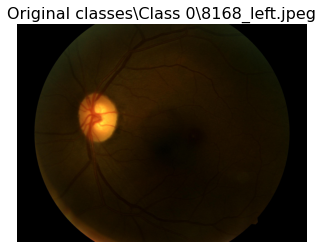

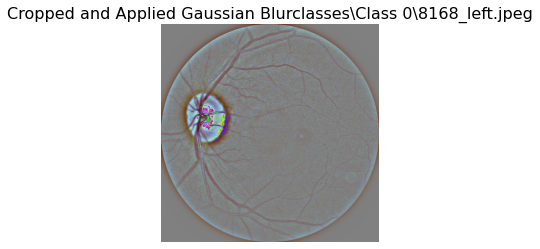

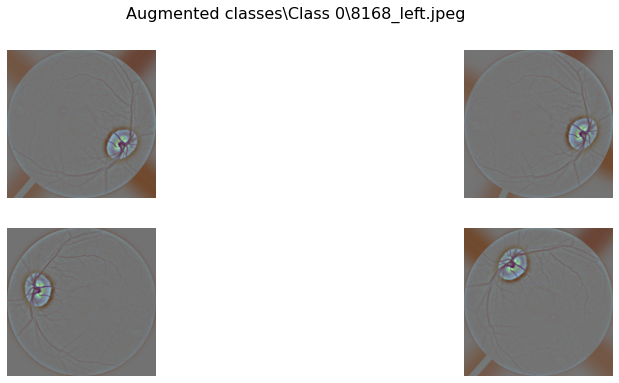

In [5]:
import matplotlib.pyplot as plt
import random
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import image_pro
import cv2
import glob

#Select a random image and follow the next step
datagen = ImageDataGenerator(rotation_range=45, 
                             horizontal_flip=True, 
                             fill_mode="nearest")
#Load example image
file_list = glob.glob("Process_Data/classes/*/*")
img_path = random.choice(file_list)
img = load_img(img_path)
iris_class = img_path.split("/")[1]
plt.imshow(img)
plt.axis("off")
plt.title("Original " + iris_class, fontsize=16)
plt.show()


#croped resized and applying gaussian blur
img = img_to_array(img)
img2=image_pro.circle_crop(img)
plt.imshow(img2.astype('uint8'))
plt.axis("off")
plt.title("Cropped and Applied Gaussian Blur" + iris_class, fontsize=16)
plt.show()


img = img_to_array(img2)
img = img.reshape((1,) + img.shape)


#Apply different augmentation techniques
n_augmentations = 4
plt.figure(figsize=(15, 6))    
i = 0
for batch in datagen.flow(img, 
                          batch_size=1, 
                          seed=21):
    plt.subplot(2, int(np.ceil(n_augmentations * 1. / 2)), i + 1)
    plt.imshow(array_to_img(batch[0]))
    plt.axis("off")
    plt.suptitle("Augmented " + iris_class, fontsize=16)    
    
    i += 1
    if i >= n_augmentations:
        break

### Cropping Resizing and Applying Gaussian Blur to Images

we need to resize the images with the expected image format. Since we're going to be using InceptionV3 in the next section we're going to match the size, 299x299, for that topology.


In [ ]:
import image_pro
from multiprocessing import Pool
import glob
from functools import partial
classes_folder = 'Process_Data/classes/'


pool = Pool()
image_list = glob.glob(classes_folder + "/*/*")
func = partial(image_pro.crop_gaussian)
pool.map(func, image_list)
pool.close()

image_pro.display_images(classes_folder)

### Create Train, Validation and Test Folders


We need to create training, validation and test folders for data ingestion and we'll use 0.7, 0.1, 0.2 ratio for this purpose.


In [ ]:
import math
import re
import sys
import shutil

#Train and Test Set Variables
train_val_test_ratio = (.7,.1,.2) # 70/10/20 Data Split
test_folder = 'Process_Data/test/'
train_folder = 'Process_Data/train/'
val_folder = 'Process_Data/val/'

file_names = os.listdir('Process_Data/classes')

#Remove Existing Folders if they exist
for folder in [test_folder, train_folder, val_folder]:
    if os.path.exists(folder) and os.path.isdir(folder):
        shutil.rmtree(folder)

#Remake Category Folders in both Train and Test Folders
for category in file_names:
    os.makedirs(test_folder + category)
    os.makedirs(train_folder + category)
    os.makedirs(val_folder + category)

#Split Data by Train Ratio and copy files to correct directory
for idx, category in enumerate(file_names):
    file_list = os.listdir(process_dataset_path + '/' + category)
    
    train_ratio = math.floor(len(file_list) * train_val_test_ratio[0])
    val_ratio = math.floor(len(file_list) * train_val_test_ratio[1])
    train_list = file_list[:train_ratio]
    val_list = file_list[train_ratio:train_ratio + val_ratio]
    test_list = file_list[train_ratio + val_ratio:]
    
    for i, file in enumerate(train_list):
        shutil.copy(process_dataset_path + '/' + category + '/' + file, train_folder + '/' + category + '/' + file)
    sys.stdout.write('Moving %s train images to category folder %s' % (len(train_list), category))  
    sys.stdout.write('\n')
    for i, file in enumerate(val_list):
        shutil.copy(process_dataset_path + '/' + category + '/' + file, val_folder + '/' + category + '/' + file)
    sys.stdout.write('Moving %s validation images to category folder %s' % (len(val_list), category))                   
    sys.stdout.write('\n')
    for i, file in enumerate(test_list):
        shutil.copy(process_dataset_path + '/' + category + '/' + file, test_folder + '/' + category + '/' + file)
    sys.stdout.write('Moving %s test images to category folder %s' % (len(test_list), category))
    sys.stdout.write('\n')
    
print("Done.")  

### Finalize Augmented Dataset for Training 


In [ ]:
import os

def data_augment(data_dir):
    list_of_images = os.listdir(data_dir)
    datagen = ImageDataGenerator(rotation_range=45, 
        horizontal_flip=True, 
        fill_mode="nearest")
    for img_name in list_of_images:
        tmp_img_name = os.path.join(data_dir, img_name)
        img = load_img(tmp_img_name)
        img = img_to_array(img)
        img = img.reshape((1,) + img.shape)
        batch = datagen.flow(img, 
            batch_size=1, 
            seed=21,
            save_to_dir=data_dir, 
            save_prefix=img_name.split(".jpg")[0] + "augmented", 
            save_format="jpg")

        batch.next()

classes_to_augment = [
    "Class 0",
    "Class 1",
    "Class 2",
    "Class 3",
    "Class 4"]

train_folder = 'Process_Data/train/'

for class_names in classes_to_augment:
    print("Currently Augmenting:", class_names)
    data_dir = os.path.join(train_folder, class_names)
    data_augment(data_dir)

### Resize New Augmented Images


In [ ]:
from multiprocessing import Pool
import image_pro
import glob

from functools import partial

train_folder = 'Process_Data/train/'

pool = Pool()
image_list = glob.glob(train_folder + "/*/*")
func = partial(image_pro.resize_image, size=299)
pool.map(func, image_list)
pool.close()
    